# Model Evaluation

This notebook will contain code that will be useful for determining the effectiveness of the produced models.

Largest connected component

In [7]:
import os
import glob
import random

import numpy as np
import matplotlib.pyplot as plt
import torch

import monai
from monai.transforms import (
    Compose,
    LoadNiftid,
    AddChanneld,
    CenterSpatialCropd,
    ScaleIntensityRangePercentilesd,
    ToTensord
)
from monai.inferers import sliding_window_inference

from lightning_modules import UNet3D, UNet3D_Large

In [8]:
data_dir = 'data/new/'

# Train imgs/masks
test_imgs = []
test_masks = []
with open(data_dir + 'test_imgs.txt', 'r') as f:
    test_imgs = [data_dir + image.rstrip() for image in f.readlines()]
with open(data_dir + 'test_masks.txt', 'r') as f:
    test_masks = [data_dir + mask.rstrip() for mask in f.readlines()]
test_dicts = [{'image': image, 'mask': mask} for (image, mask) in zip(test_imgs, test_masks)]

# Basic transforms
data_keys = ["image", "mask"]
data_transforms = Compose(
    [
        LoadNiftid(keys=data_keys),
        AddChanneld(keys=data_keys),
        ScaleIntensityRangePercentilesd(
            keys='image',
            lower=25,
            upper=75,
            b_min=-0.5,
            b_max=0.5
        )
    ]
)
test_dataset = monai.data.CacheDataset(
    data=test_dicts,
    transform=Compose(
        [
            data_transforms,
            ToTensord(keys=data_keys)
        ]
    ),
    cache_rate=1.0
)

Load and cache transformed data: 100%|██████████| 80/80 [00:00<00:00, 187036.97it/s]


In [9]:
test_dataset[0]['image'].shape

torch.Size([1, 300, 300, 42])

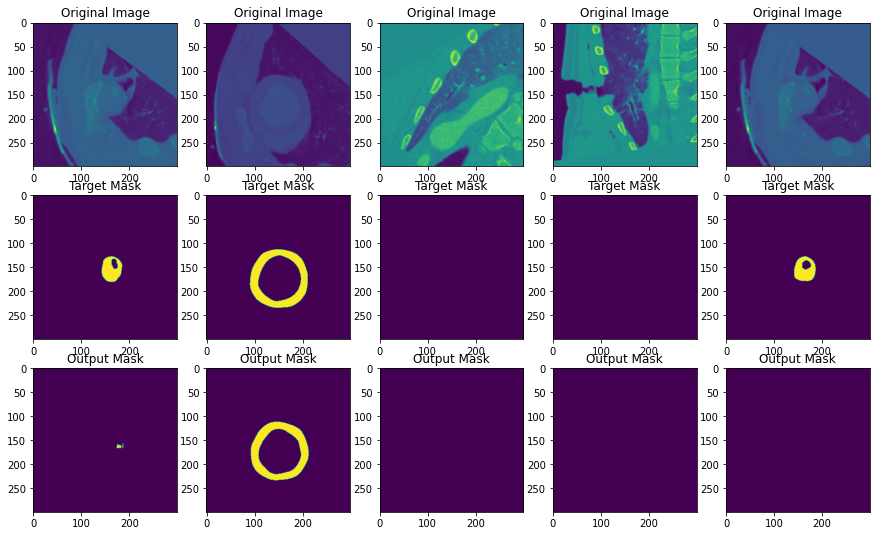

In [13]:
# model = UNet3D.UNet3D.load_from_checkpoint('models/2020-10-14_UNet_NewData/epoch=89-val_loss=0.10.ckpt').cuda()
model = UNet3D_Large.UNet3D.load_from_checkpoint('models/2020-10-15_UNet_MoreParams/epoch=74-val_loss=0.10.ckpt').cuda(1)
model.eval()

test_samples = random.sample(range(len(test_dataset)), 5)
fig, axs = plt.subplots(3, 5, figsize=(15, 9))
for i in range(5):
    sample = test_dataset[test_samples[i]]
    test_image = sample['image'].unsqueeze(0).cuda(1)
    slice_depth = random.randint(0, test_image.size()[4] - 1)
    test_mask = sliding_window_inference(
        test_image,
        roi_size=[256, 256, 16],
        sw_batch_size=64,
        predictor=model,
        device=torch.device('cuda:1')
    )
    test_mask = test_mask.argmax(1).squeeze(0).cpu()
    
    axs[0, i].imshow(sample['image'][0, :, :, slice_depth])
    axs[0, i].set_title('Original Image')

    axs[1, i].imshow(sample['mask'][0, :, :, slice_depth])
    axs[1, i].set_title('Target Mask')

    axs[2, i].imshow(test_mask[:, :, slice_depth])
    np.save('test' + str(i), test_mask[:, :, slice_depth])
    axs[2, i].set_title('Output Mask')

plt.savefig('results/' + model.hparams.name + '.png')